# Lab Three: Multi-modal and Multi-task

#### CS8321: Neural Networks and Machine Learning
    
Johnathan Barr - 39854013
<br>
Will Lacey - 45906124

## Lab Description
<em>In this lab, you will implement a multi-task network (possibly multi-modal) that classifies interactions between compounds/ ligands with proteins in the ChEMBL database (https://www.ebi.ac.uk/chembl/). The objective is to classify which ligands bind to which targets. Each target will be a separate task working from a  shared ligand representation. </em>

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [2]:
from keras.layers import Input, Dense
from keras.models import Model

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import rdkit
from rdkit import ML
from rdkit.ML import Scoring
from rdkit.ML.Scoring import Scoring
from rdkit import Chem

import seaborn as sns

from random import shuffle

import sklearn
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score 
from sklearn.metrics import precision_score, mean_squared_log_error

import warnings
warnings.simplefilter('ignore')

## Downloading the ChEMBL Dataset

<em>[<strong>10 points</strong>] Download the ChEMBL database or setup queries to download a subset of the database. An already processed version of the dataset is available here (thanks to Niraj Verma): https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04</em>

We decided to opt for the preprocessed version of the dataset provided by Niraj Verma. The following cell has been adapted from the SMU box link, which will parse through the dataset as a .csv file and save the information to a numpy cache file.

In [3]:
# export data as .npy
f = open('data/data.csv', 'r', encoding="ISO-8859-1")
lines = f.readlines()
f.close()

flis = [] # will have [id, ic50_val, unit, target, smiles] 

for line in lines[1:]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')

    if len(lis) < 36:
        continue
    
    
    #print (lis[0], lis[3], lis[8], lis[36])
    # [id, ic50_val, unit, target, smiles]

    flis.append([lis[0], lis[3], lis[4], lis[8], lis[36]])
    #break

# I have no idea why python adds \x00 to each string
# Therefoe I removed it

for i in range (len(flis)):
    flis[i] = [j.replace('\x00','') for j in flis[i]]
    flis[i] = [j.replace('"','') for j in flis[i]]

# Some of the data have smiles or IC50 missing
# So I removed them as well
list = []
for i in flis:
    if len(i[1]) != 0 and len(i[-1]) != 0:
        #print (i)
        list.append(i)

X, t, y = [], [], []
for i in list:
    if i[2] == 'nM':
        if len(i[-1]) == 0 or len(i[-2]) ==0 or len(i[1]) ==0:
            print ('Thers a problem !!')
        X.append(i[-1])
        t.append(i[-2])
        y.append(i[1])

# smiles is the string representation of each ligand
# target is the protein where ligand binds (treat it as different schools)
# ic50 is the score
np.save('data/data.npy', {'smiles':X, 'target':t, 'ic50':y})

After running the previous cell, we then load the cached data. This is so we can save time when we boot up this notebook in the future. 

In [4]:
data = np.load('data/data.npy', allow_pickle=True)

Okay! Let's get to it!

We're first going to convert the data to a pandas DataFrame object. This will help us tinker with the data as we go on. 

In [5]:
df = pd.DataFrame(data.tolist())
df

,smiles,target,ic50
0,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1,CHEMBL664913,11600
1,NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12,CHEMBL812106,9000
2,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...,CHEMBL811877,17900
3,COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23,CHEMBL664920,4200
4,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,CHEMBL664913,2700
...,...,...,...
747912,Cn1cc(cn1)S(=O)(=O)N2CCC3=Cc4c(C[C@@]3(C2)C(=O...,CHEMBL4051182,210
747913,CN(C)CCCNc1cc(ncn1)C2(CC2)C(=O)Nc3cc(ccc3C)C(=...,CHEMBL4050074,33.8
747914,CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5sc(C)cc4...,CHEMBL4059187,0.384
747915,CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5[nH]ccc4...,CHEMBL4059187,0.27


Let's also check out some of the cool functionality of RDKit and view a random molecule. This will be done by grabbing the molecule's smiles and converting it into a molecular representation.

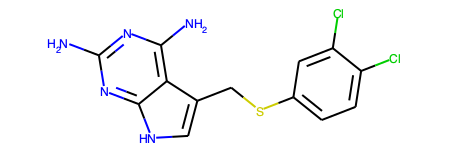

In [6]:
# convert a molecule's smiles to a graphical representation
m_smile = df['smiles'].get(0)
m = Chem.MolFromSmiles(m_smile)
m

For this lab we will take the canonical smiles representation of a molecule and convert it into its RDKFingerprint through RDKit's libary. Using just the molecule's encoded fingerprint, we then try to predict its binding affinity to other proteins. 

## Binarize the Binding Affinity

<em>[<strong>5 points</strong>] Binarize the binding affinity for each ligand in the assay. That is, convert the continuous measure of binding to binary. You should use the column 'IC50' for this calculation. Anything below 300 nM should be considered as an active binding. Anything above 10 uM should be considered non-binding (inactive). </em>

First, let's write the function to binarize the IC50 column in the pandas DataFrame.

In [7]:
def binarize_affinity(value):
    """
    Binarizes the ic50 value for a particular molecule and target; 
        if the value is between 300nM and 10uM, return None
    """
    value = float(value)
    if value < 300.0:
        return 1
    elif value > 10000.0:
        return 0
    else:
        return None

Cool, no sweat. We decided to also throw out all values that were in between the binding threshold.

In [8]:
df['ic50'] = df['ic50'].apply(binarize_affinity)
df = df[df['ic50'].notna()]
df

,smiles,target,ic50
0,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1,CHEMBL664913,0.0
2,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...,CHEMBL811877,0.0
5,Cc1c(CN(C=O)c2ccc(Cl)c(Cl)c2)cnc3nc(N)nc(N)c13,CHEMBL665696,1.0
6,Cc1ccc2[nH]c(O)c(\N=N\C(=N)S)c2c1,CHEMBL805131,0.0
7,CN(Cc1ccc2nc(N)nc(N)c2n1)c3cccc(Cl)c3,CHEMBL665702,1.0
...,...,...,...
747910,C[C@@H](Oc1cc2ccn(CCC(=O)O)c2cc1Cl)c3ccccn3,CHEMBL4051432,1.0
747912,Cn1cc(cn1)S(=O)(=O)N2CCC3=Cc4c(C[C@@]3(C2)C(=O...,CHEMBL4051182,1.0
747913,CN(C)CCCNc1cc(ncn1)C2(CC2)C(=O)Nc3cc(ccc3C)C(=...,CHEMBL4050074,1.0
747914,CN1CCN(Cc2ccc(NC(=O)c3n[nH]cc3Nc4ncnc5sc(C)cc4...,CHEMBL4059187,1.0


## Featurize each Ligand
<em>[<strong>10 points</strong>] Featurize each ligand using RDKit (https://www.rdkit.org). This will convert the ligand representation into a binary vector of features. Mention any hyper parameters you use. </em>

The next two functions are helper functions for data processing. 

The first of the two is a function for filtering the top targets in the database based on their frequency of occurrence. In the next few cells, we decided to first remove discrepancies in the dataset that have errors in their information, then calculate the most occurring targets. We often found rows that were tabulated incorrectly and would fail when we attempted to take their RDKFingerprint. We will showcase this later.

Next is the helper function to prepare the featurization of each ligand. This method simply takes a string of a binary code and converts it into an array.

In [9]:
# function to take the top x targets in the dataset based on number of occurrence
def top(x):
    """ Takes the top x most occurring targets in the DataFrame """
    # take the top, most tested proteins, sorting them from most to least tested
    counts_series = df['target'].value_counts()

    # grab the target names of the top x most tested proteins
    top_targets = counts_series[0:x].index.values.tolist()

    # retain only top x proteins in the dataframe, remove others
    return df[df['target'].isin(top_targets)]


def vectorize_binary_fingerprint(binary_fingerprint):
    """ Vectorizes the binary fingerprint string for a given molecule """
    vector = []
    for i in binary_fingerprint:
        vector.append(int(i))
    return vector

We found that if we first took the top 200 most occurring targets, we could remove the incomplete or incorrectly entered data and still have 100 elements remaining. This was done so we wouldn't have to take the fingerprint of every molecule in the database. 

Thus, this next cell performs the featurization of the top 200 most occurring targets.

In [23]:
df = top(200)
smiles_data = df['smiles'].tolist()
featurized_data = []

for smiles in smiles_data:
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        fingerprint = Chem.RDKFingerprint(molecule)
        binary_fingerprint = fingerprint.ToBitString()
        featurized_molecule = vectorize_binary_fingerprint(binary_fingerprint)
        featurized_data.append(featurized_molecule)
    else:
        featurized_data.append(None)

This cell produces a long series of RDKit Error messages that have been suppressed to consolidate this lab


Wow, this looks pretty messy. We couldn't find a better way to do this, nor could we suppress the error logs of RDKit. This was caused by RDKit attempting to take the fingerprint of an incorrectly entered molecule's canonical smiles. 

Let's add the featurized smiles data back into the pandas DataFrame object.

In [11]:
df['featurized_smiles'] = featurized_data
df = df[df['featurized_smiles'].notna()]
df

,smiles,target,ic50,featurized_smiles
67,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839,1.0,"[1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, ..."
68,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662,1.0,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
69,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839,1.0,"[1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
71,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662,1.0,"[1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, ..."
76,CN(Cc1ccccc1)c2cnc3nc(N)nc(N)c3c2,CHEMBL830839,1.0,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, ..."
...,...,...,...,...
747291,CC(C)(C)C(=O)CN1CC2CN(CCCNc3ccc(cc3)C#N)CC(C1)O2,CHEMBL4017550,0.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
747316,NC(=N)NC(=O)Cc1c(Cl)cccc1Cl,CHEMBL4028921,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
747395,CC(C)[C@H](O)C(=O)N[C@@H](C)C(=O)N[C@@H]1C(=O)...,CHEMBL4017550,0.0,"[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, ..."
747457,S=P(N1CC1)(N2CC2)N3CC3,CHEMBL4017550,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


## Filtering the Top 100 Targets

<em>[<strong>10 points</strong>] Filter the database to the top 100 targets in the database. You will need a definition of "top" such as the targets with the most assays. From these top 100 targets, save the ligands that have an assay result for each of the targets. </em>

Okay, now that we have removed the incorrect entries in the data, we now take the rows where the top 100 targets are most frequently occuring. 

Since it took forever to featurize the data, we save this to a pickle file so that we can load up the preprocessed data for the next time we work on the lab.

In [12]:
df = top(100)
df.to_pickle("data/top_data.pkl")

In [3]:
df = pd.read_pickle("data/top_data.pkl")

## Train a multi-task model

<em>[<strong>20 points</strong>] Train a multi-task model (one model for each target). Use an 80/20 split for each target.</em>

Alright time for constructing the model! We first break up the dataset to a sklearn Bunch object for each target that is found within the database. This is so we can construct a multi-task model.

In [4]:
top_targets = df['target'].value_counts().index.values.tolist()
tasks = dict()

for target in top_targets:
    target_rows = df.loc[df['target'] == target]
    tasks[target] = Bunch(data   = np.array(target_rows.featurized_smiles.to_list()),
                          labels = np.array(target_rows.ic50.to_list()))

Now that we have fractured the dataset, we divide our data into training and testing dictionaries with an 80 - 20 split. 

In [5]:
X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x in tasks.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(tasks[x].data, 
                                                        tasks[x].labels, 
                                                        test_size=0.2,
                                                        random_state=42)

Because we're creating a multi-task classifier, we will resultantly have 100 different models, one for each class. In theory this will perform better than a standard sequential model with 100 different outputs because each individual model can learn the statistics strictly pertaining to its own model and not conflate its own learned patterns with another classifier for a different target. 

This next cell sets up the architecture for our models.

In [10]:
input_shape = 2048

inputs = Input(shape=(input_shape,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()

for x in tasks.keys():
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='mean_squared_error')
    models_mtl[x] = model

Let's begin training. 

In [11]:
%%time

EPOCHS = 20 # number of epochs for training
all_keys = [key for key in tasks.keys()] # list of each keys 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x], 
                          y_train[x], 
                          verbose=0)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, CPU times: user 4min 8s, sys: 13.6 s, total: 4min 21s
Wall time: 3min 42s


Now that we have finished training we can grab the binding predictions for each class. We report these results in the next few cells.

In [12]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 3.14 s, sys: 95.7 ms, total: 3.24 s
Wall time: 3.05 s


## Report the results

<em>[<strong>20 points</strong>] Report the results using AUC, BEDROC, and Enrichment factor. These metrics are easily calculated using the RDKit scoring library. Discuss the results (you will need to look up each evaluation metric to interpret the result). You may be interested in page 6 of the following document: https://www.dropbox.com/s/6je37ml475vg3ep/Srinivas2018ImplictDescriptorUnderReview.pdf?dl=0 </em>


Evaluation metrics defined here: https://new.pharmacelera.com/science/measuring-virtual-screening-accuracy/

First we decided to try a Bland-Altman plot to see the measure of the agreeableness between the actual target values and our predicted target values.

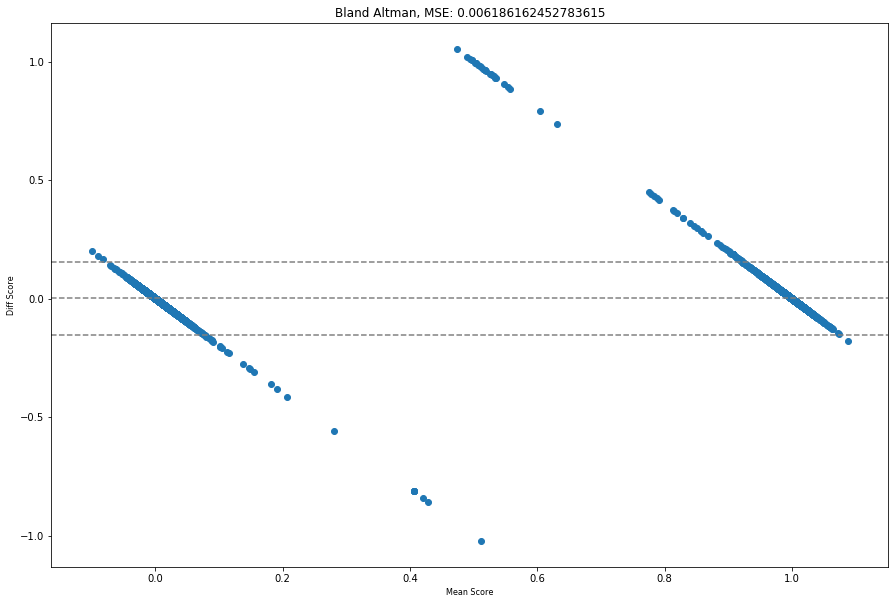

In [13]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.figure(figsize=(15,10))
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.title("Bland Altman, MSE: "+str(mean_squared_error(data1,data2)))
    plt.xlabel('Mean Score', fontsize=8)
    plt.ylabel('Diff Score', fontsize=8)
    plt.show()

bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))

So it turns out that the classifier did okay. By no means did it perform spectacularly. Most of our datapoints fall upon the zero x axis which is good, but a good amount are certainly inaccurate. It's hard to know if our preprocessing prevented our model in learning core relationships between the top 100 molecules, or if our model was poorly constructed. In the exceptional work, we will get to this later. 

**Area Under the ROC Curve (AUC)** represents degree or measure of separability, which indicates how well the model can distinguish between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s (true positives)

In [93]:
scores = np.hstack((yhat_mtl, y_mtl))
col = 1

In [91]:
rdkit.ML.Scoring.Scoring.CalcAUC(scores, col)

0.8492642799212144

**Boltzmann-Enhanced Discrimination of ROC (BEDROC)** is a metric that assigns more weight to early ranked molecules than late ranked molecules. The active compounds are weighted depending on their position in the ranking using an exponential function, ranging from 1.0 for the top ranked compound to close to zero for the lowest ranked compound. The exponential factor determines how much the BEDROC parameter focuses on the top of the list. The drawbacks of this metric are its dependency of the ratio of active/inactive compounds and the dependency of an extrinsic variable (adjustable exponential factor). That means that the value depends on the method and a particular experiment. Hence, sets with different active/inactive compound ratios cannot be compared directly using such a metric.

In [102]:
# alpha = hyperparam that tells you how much do you care about being in the top x% 
# small = care a lot, large = don't care = AUC
alpha1 = 0.1
alpha2 = 0.9

print(rdkit.ML.Scoring.Scoring.CalcBEDROC(scores, col, alpha1))
print(rdkit.ML.Scoring.Scoring.CalcBEDROC(scores, col, alpha2))

0.8526675541990919
0.8788541634277337


As you can see above, changing the alpha value does not affect our BEDROC score too much. This would indicate that our particular dataset does not have a strong dependence on the rankings of the compounds

**Enrichment Factor (EF)** measures the fraction of active compounds found in a specific percentage, solving the problem of comparing the results for datasets with different active / inactive compound ratios. EF has intuitive interpretation related to the purpose of the VS itself (the ability to select a subset of molecules with a promising chance of finding a hit compound). However, although the EF metric is independent of adjustable parameters, it is still inﬂuenced by the number of active compounds in the dataset. EF becomes smaller if fewer inactive molecules are initially present.

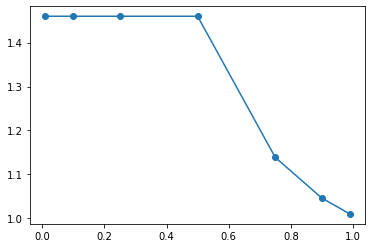

In [105]:
# smaller = harder for algorithm to perform well
fractions = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

enrichment_factors = rdkit.ML.Scoring.Scoring.CalcEnrichment(scores, col, fractions) 

plt.plot(fractions, enrichment_factors, marker='o')
plt.show()

Understanding the graph above, as the fractions used by the EF increase, the EF itself actually decreases. This indicates that fewer inactive molecules are initially present in the dataset as a whole when compared to fractions of it. 

## Additional Analysis

<em>[<strong>10 points</strong>] Finally, you have free reign to perform any other analysis. A suggested analysis is to add an additional mode of input data such as another fingerprint for each ligand.</em>

We decided to remake the multi-task classifier's architecture by adding another perceptron layer and increasing the number of neurons within the layers. By doing this and increasing the number of epochs, we hope to accomplish a superior model to the one from before. 

Similar to before, let's start with building the model.

In [14]:
input_shape = 2048

inputs = Input(shape=(input_shape,))
shared_mlp = Dense(1000, activation='relu')(inputs)
shared_mlp = Dense(500, activation='relu')(shared_mlp)
shared_mlp = Dense(100, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()

for x in tasks.keys():
    personal_layer = Dense(50, activation='softmax')(shared_mlp)
    output_layer = Dense(1)(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='rmsprop', loss='mean_squared_error')
    models_mtl[x] = model

We are now going to train the new model for more than twice the amount of time.

In [15]:
%%time

EPOCHS = 50 # number of epochs for training
all_keys = [key for key in tasks.keys()] # list of each keys 

for i in range(EPOCHS):
    print('Epoch',i,end=', ')
    shuffle(all_keys)
    for x in all_keys:
        models_mtl[x].fit(X_train[x], 
                          y_train[x], 
                          verbose=0)

Epoch 0, Epoch 1, Epoch 2, Epoch 3, Epoch 4, Epoch 5, Epoch 6, Epoch 7, Epoch 8, Epoch 9, Epoch 10, Epoch 11, Epoch 12, Epoch 13, Epoch 14, Epoch 15, Epoch 16, Epoch 17, Epoch 18, Epoch 19, Epoch 20, Epoch 21, Epoch 22, Epoch 23, Epoch 24, Epoch 25, Epoch 26, Epoch 27, Epoch 28, Epoch 29, Epoch 30, Epoch 31, Epoch 32, Epoch 33, Epoch 34, Epoch 35, Epoch 36, Epoch 37, Epoch 38, Epoch 39, Epoch 40, Epoch 41, Epoch 42, Epoch 43, Epoch 44, Epoch 45, Epoch 46, Epoch 47, Epoch 48, Epoch 49, CPU times: user 55min 51s, sys: 55min 12s, total: 1h 51min 3s
Wall time: 29min 46s


Done. Now let's get our predictions and see how the model performed.

In [16]:
%%time
y_mtl=[]
yhat_mtl=[]

for x in X_test.keys():
    yhat_mlp = models_mtl[x].predict(X_test[x])

    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

CPU times: user 6.76 s, sys: 989 ms, total: 7.75 s
Wall time: 5.35 s


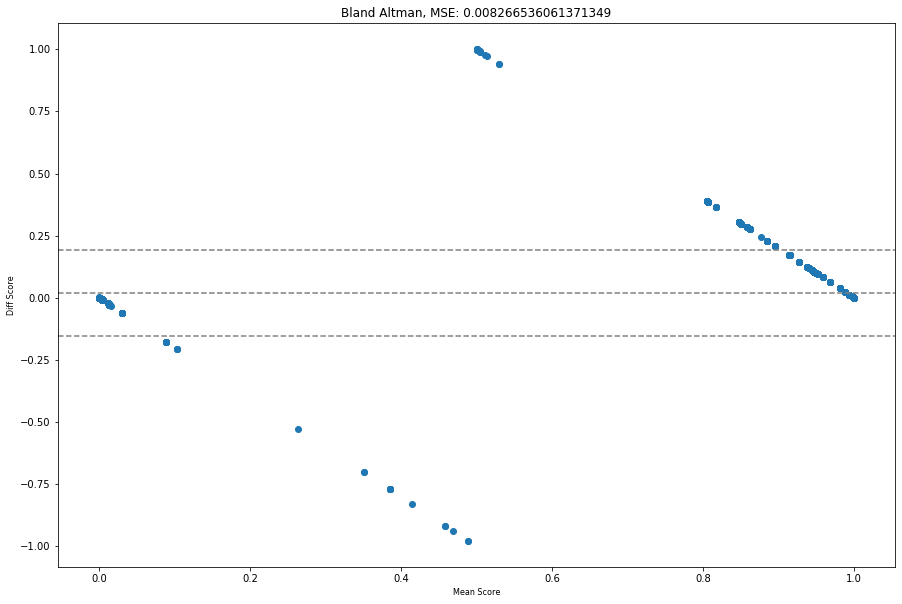

In [17]:
bland_altman_plot(np.concatenate(y_mtl), np.concatenate(yhat_mtl))

In [21]:
# Calculating AUC
scores = np.hstack((yhat_mtl, y_mtl))
col = 1
rdkit.ML.Scoring.Scoring.CalcAUC(scores, col)

0.8490325570617543

In [19]:
# Calculating BEDROC
alpha1 = 0.1
alpha2 = 0.9

print(rdkit.ML.Scoring.Scoring.CalcBEDROC(scores, col, alpha1))
print(rdkit.ML.Scoring.Scoring.CalcBEDROC(scores, col, alpha2))

0.852444914382772
0.8786952017400618


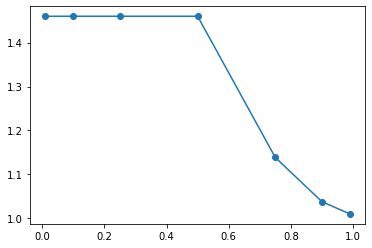

In [20]:
# Calculating Enrichment
fractions = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

enrichment_factors = rdkit.ML.Scoring.Scoring.CalcEnrichment(scores, col, fractions) 

plt.plot(fractions, enrichment_factors, marker='o')
plt.show()

Looking at the new scores, we see that the model performed almost identically to the previous model. To improve our overall performance, it would probably be best to look at the original dataset and perform our own preprocessing. This way, we could hope to retain more of the dataset and avoid removing a wide variety of the data rows. Additionally, it would most likely help if we used more of the dataset's features provided to us. However, this would take an increased level of understanding of the problem and potentially how the ligands and proteins interact with one another. 